# 1. Import Libraries

In [8]:
# Connecting google colab to google drive

from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [1]:
# Setting up memory in GPU. It's important if we use multi-GPU as tensorflow memory could error.

import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)

In [2]:
# Importing necessery library to process the data such as tensorflow, numpy, pandas, matplotlib, skitlearn, etc.

import math
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import tensorflow as tf
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

from math import *
from collections import Counter

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from tensorflow import keras
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam,  RMSprop
from tensorflow.python.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, LSTM, GRU, Embedding,\
      BatchNormalization, LeakyReLU, Dropout, ReLU, Bidirectional, GlobalMaxPooling1D

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import chi2, RFE, SelectFromModel, SelectKBest
from sklearn.preprocessing import PowerTransformer, MinMaxScaler, LabelEncoder, RobustScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, RocCurveDisplay,\
      classification_report, mean_squared_error, r2_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import PassiveAggressiveClassifier, LogisticRegression

from sklearn.ensemble import (
    BaggingClassifier,
    StackingClassifier,
    AdaBoostClassifier,
    ExtraTreesClassifier,
    RandomForestClassifier,
    RandomForestClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
)

from xgboost import XGBClassifier


# 2. Load Data

In [3]:
# Importing DataTrain.csv from google drive. After importing the dataset, we drop the duplicate rows and show the example data.

# data = pd.read_csv('/content/gdrive/MyDrive/Binar - Data Science/Challenge 2/Dataset/DataTrain.csv')
data = pd.read_csv('Dataset\DataTrain.csv')
data = data.drop_duplicates()
data

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
1,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
2,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
3,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no
4,MA,121,area_code_510,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4245,MT,83,area_code_415,no,no,0,188.3,70,32.01,243.8,88,20.72,213.7,79,9.62,10.3,6,2.78,0,no
4246,WV,73,area_code_408,no,no,0,177.9,89,30.24,131.2,82,11.15,186.2,89,8.38,11.5,6,3.11,3,no
4247,NC,75,area_code_408,no,no,0,170.7,101,29.02,193.1,126,16.41,129.1,104,5.81,6.9,7,1.86,1,no
4248,HI,50,area_code_408,no,yes,40,235.7,127,40.07,223.0,126,18.96,297.5,116,13.39,9.9,5,2.67,2,no


# 3. Initial Analysis

### 3.1. Metadata

In [11]:
# To show metadata of DataTrain file such as columns' name, non-null count, data type, number of data, and file size.
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4250 entries, 0 to 4249
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          4250 non-null   object 
 1   account_length                 4250 non-null   int64  
 2   area_code                      4250 non-null   object 
 3   international_plan             4250 non-null   object 
 4   voice_mail_plan                4250 non-null   object 
 5   number_vmail_messages          4250 non-null   int64  
 6   total_day_minutes              4250 non-null   float64
 7   total_day_calls                4250 non-null   int64  
 8   total_day_charge               4250 non-null   float64
 9   total_eve_minutes              4250 non-null   float64
 10  total_eve_calls                4250 non-null   int64  
 11  total_eve_charge               4250 non-null   float64
 12  total_night_minutes            4250 non-null   f

In [12]:
# Showing statistical info of each column such as count, mean, standard deviation, lowest value, quartile 1, 2, and 3, and highest value.

data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
account_length,4250.0,100.236235,39.698401,1.0,73.0000,100.00,127.0000,243.00
number_vmail_messages,4250.0,7.631765,13.439882,0.0,0.0000,0.00,16.0000,52.00
total_day_minutes,4250.0,180.259600,54.012373,0.0,143.3250,180.45,216.2000,351.50
total_day_calls,4250.0,99.907294,19.850817,0.0,87.0000,100.00,113.0000,165.00
total_day_charge,4250.0,30.644682,9.182096,0.0,24.3650,30.68,36.7500,59.76
total_eve_minutes,4250.0,200.173906,50.249518,0.0,165.9250,200.70,233.7750,359.30
total_eve_calls,4250.0,100.176471,19.908591,0.0,87.0000,100.00,114.0000,170.00
total_eve_charge,4250.0,17.015012,4.271212,0.0,14.1025,17.06,19.8675,30.54
total_night_minutes,4250.0,200.527882,50.353548,0.0,167.2250,200.45,234.7000,395.00
total_night_calls,4250.0,99.839529,20.093220,0.0,86.0000,100.00,113.0000,175.00


In [13]:
# Showing numbur of duplicate and null data

print(f'Number of duplicates data : {data.duplicated().sum()}')
print(f'Number of null data       : {data.isnull().sum().sum()}')

Number of duplicates data : 0
Number of null data       : 0


In [14]:
# Showing the percentage of missing values for each column so we can decide whether the data is healthy or not

no_of_columns = data.shape[0]
percentage_of_missing_data = data.isnull().sum()/no_of_columns
print(round(percentage_of_missing_data*100), 2)

state                            0.0
account_length                   0.0
area_code                        0.0
international_plan               0.0
voice_mail_plan                  0.0
number_vmail_messages            0.0
total_day_minutes                0.0
total_day_calls                  0.0
total_day_charge                 0.0
total_eve_minutes                0.0
total_eve_calls                  0.0
total_eve_charge                 0.0
total_night_minutes              0.0
total_night_calls                0.0
total_night_charge               0.0
total_intl_minutes               0.0
total_intl_calls                 0.0
total_intl_charge                0.0
number_customer_service_calls    0.0
churn                            0.0
dtype: float64 2


In [15]:
# Showing the number of unique data in each column

data.nunique()

state                              51
account_length                    215
area_code                           3
international_plan                  2
voice_mail_plan                     2
number_vmail_messages              46
total_day_minutes                1843
total_day_calls                   120
total_day_charge                 1843
total_eve_minutes                1773
total_eve_calls                   123
total_eve_charge                 1572
total_night_minutes              1757
total_night_calls                 128
total_night_charge                992
total_intl_minutes                168
total_intl_calls                   21
total_intl_charge                 168
number_customer_service_calls      10
churn                               2
dtype: int64

### 3.2. Columns Processing

In [4]:
# To get columns' names having integer, float, and object data types. This process is crucial in the EDA process since we don't want an error message saying "This function can't process categorical column" in the future.

numerical_int_columns = list(data.select_dtypes('integer').columns)
numerical_float_columns = list(data.select_dtypes('float').columns)
categorical_columns = [column_name for column_name in data.columns if data[column_name].dtype == 'object']
numerical_columns = numerical_int_columns + numerical_float_columns

print(f'Numerical Int Columns   : {numerical_int_columns}')
print(f'Numerical Float Columns : {numerical_float_columns}')
print(f'Numerical Columns       : {numerical_columns}')
print(f'Categorical Columns     : {categorical_columns}')

Numerical Int Columns   : ['account_length', 'number_vmail_messages', 'total_day_calls', 'total_eve_calls', 'total_night_calls', 'total_intl_calls', 'number_customer_service_calls']
Numerical Float Columns : ['total_day_minutes', 'total_day_charge', 'total_eve_minutes', 'total_eve_charge', 'total_night_minutes', 'total_night_charge', 'total_intl_minutes', 'total_intl_charge']
Numerical Columns       : ['account_length', 'number_vmail_messages', 'total_day_calls', 'total_eve_calls', 'total_night_calls', 'total_intl_calls', 'number_customer_service_calls', 'total_day_minutes', 'total_day_charge', 'total_eve_minutes', 'total_eve_charge', 'total_night_minutes', 'total_night_charge', 'total_intl_minutes', 'total_intl_charge']
Categorical Columns     : ['state', 'area_code', 'international_plan', 'voice_mail_plan', 'churn']


In [5]:
# impute_nan function will fill null value with a mean value for numerical column and a mode value for categorical column

def impute_nan(data):
    for col in numerical_columns:
        data[col] = data[col].fillna(data[col].mean())

    for col in categorical_columns:
        data[col] = data[col].fillna(data[col].value_counts().index[0])
impute_nan(data)

In [6]:
# To save memory, we downcasting the data types for each columns by using downcasting_dtypes function. It's very helpful if we are dealing with a huge dataset.

def downcasting_dtypes(data):
    fcols = data.select_dtypes('float').columns
    icols = data.select_dtypes('integer').columns

    data[fcols] = data[fcols].apply(pd.to_numeric, downcast='float')
    data[icols] = data[icols].apply(pd.to_numeric, downcast='integer')

downcasting_dtypes(data)

In [7]:
# Converting categorical column to numerical (integer) using LabelEncoder so we are able to see insight from all column.

def change_columns_to_numerical(data):
    LE = LabelEncoder()

    categorical_columns = [column_name for column_name in data.columns if data[column_name].dtype == 'object']

    for column in categorical_columns:
        data[column] = LE.fit_transform(data[column])
        data[column] = data[column].apply(pd.to_numeric, downcast='integer')
        print(f'{column} : {LE.classes_}')

change_columns_to_numerical(data)

state : ['AK' 'AL' 'AR' 'AZ' 'CA' 'CO' 'CT' 'DC' 'DE' 'FL' 'GA' 'HI' 'IA' 'ID'
 'IL' 'IN' 'KS' 'KY' 'LA' 'MA' 'MD' 'ME' 'MI' 'MN' 'MO' 'MS' 'MT' 'NC'
 'ND' 'NE' 'NH' 'NJ' 'NM' 'NV' 'NY' 'OH' 'OK' 'OR' 'PA' 'RI' 'SC' 'SD'
 'TN' 'TX' 'UT' 'VA' 'VT' 'WA' 'WI' 'WV' 'WY']
area_code : ['area_code_408' 'area_code_415' 'area_code_510']
international_plan : ['no' 'yes']
voice_mail_plan : ['no' 'yes']
churn : ['no' 'yes']


### 3.3. EDA

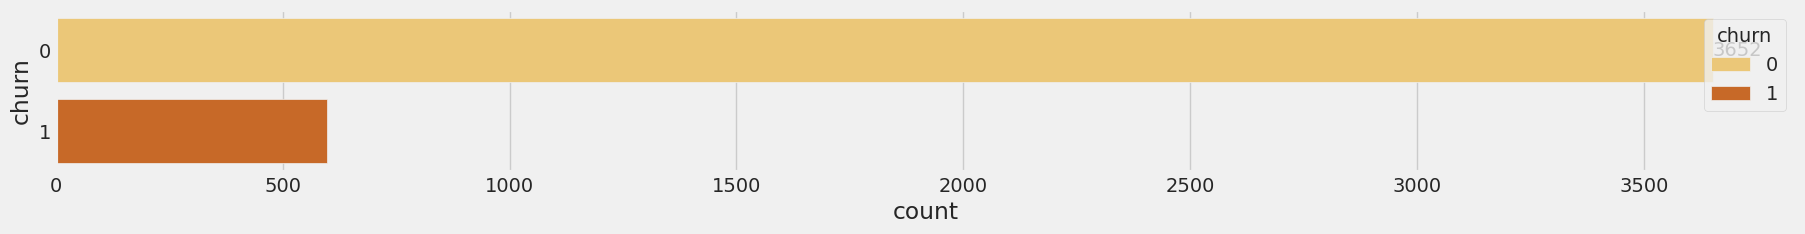

In [37]:
# This graph shows the number of churn columns. As we can see, "No" value is the majority in the data and if we don't do anything with the data, it will cause some problems especially when we make prediction using model.

plt.subplots(figsize = (20,2))
ax = sns.countplot(data = data, y = 'churn', palette='YlOrBr', hue= 'churn')
ax.bar_label(ax.containers[0])
plt.show()

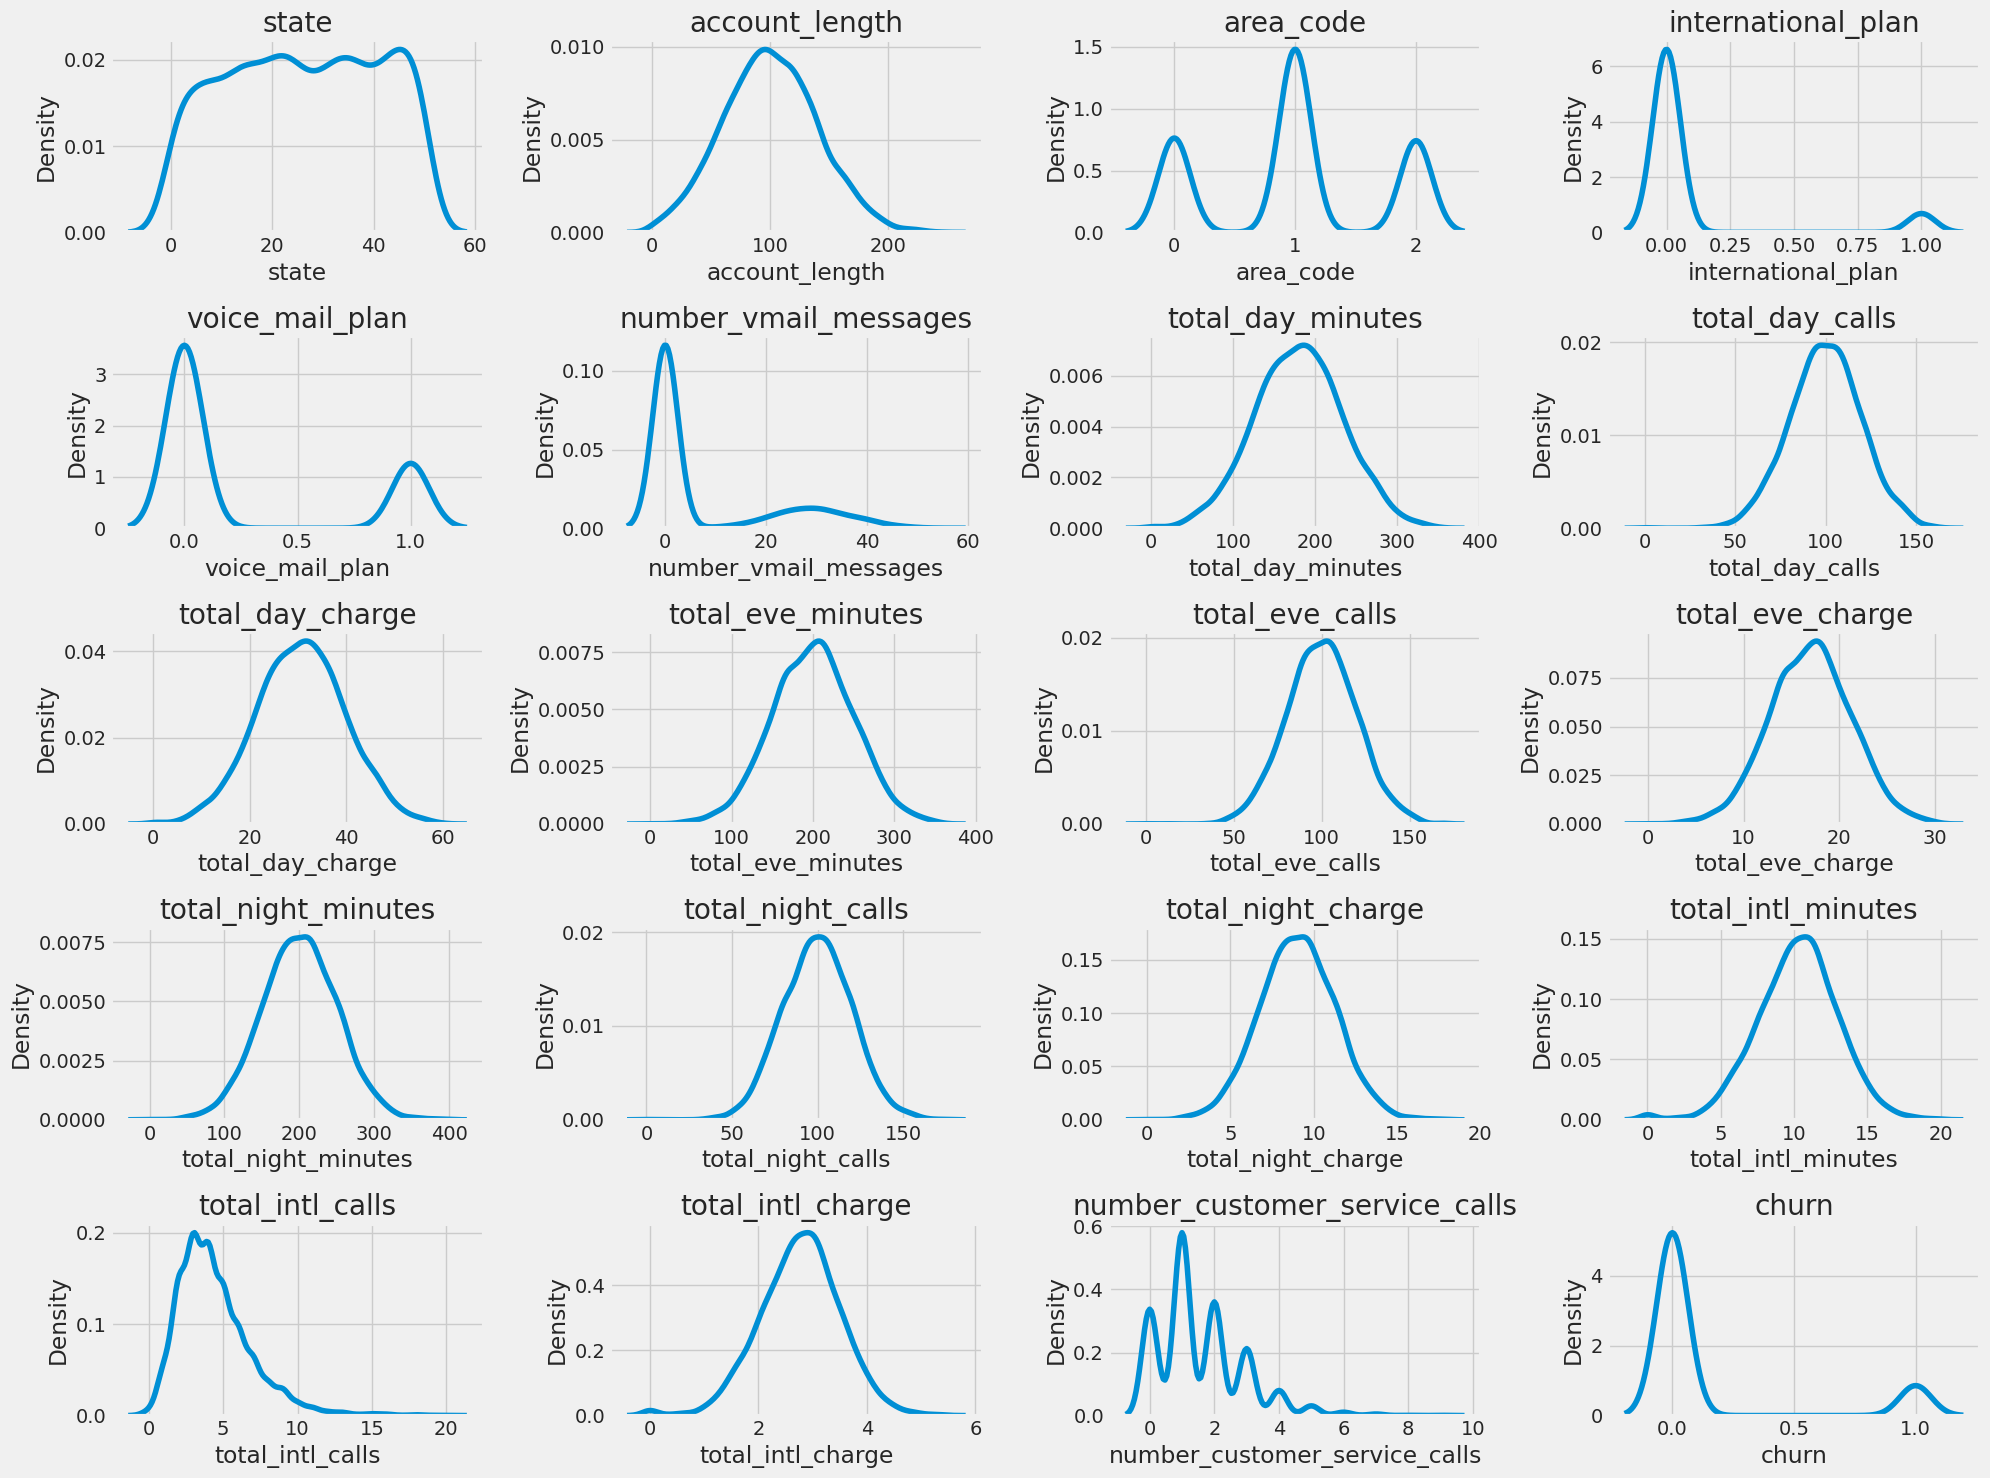

In [39]:
# This graph show the density and distribution value for each columns.

num_cols = 4
num_rows = math.ceil(len(data.columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 15))

for i, column in enumerate(data.columns):
    row = i // num_cols
    col = i % num_cols
    sns.kdeplot(data = data, x = column, ax=axes[row, col]) \
        .set_title(column)


for i in range(len(data.columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

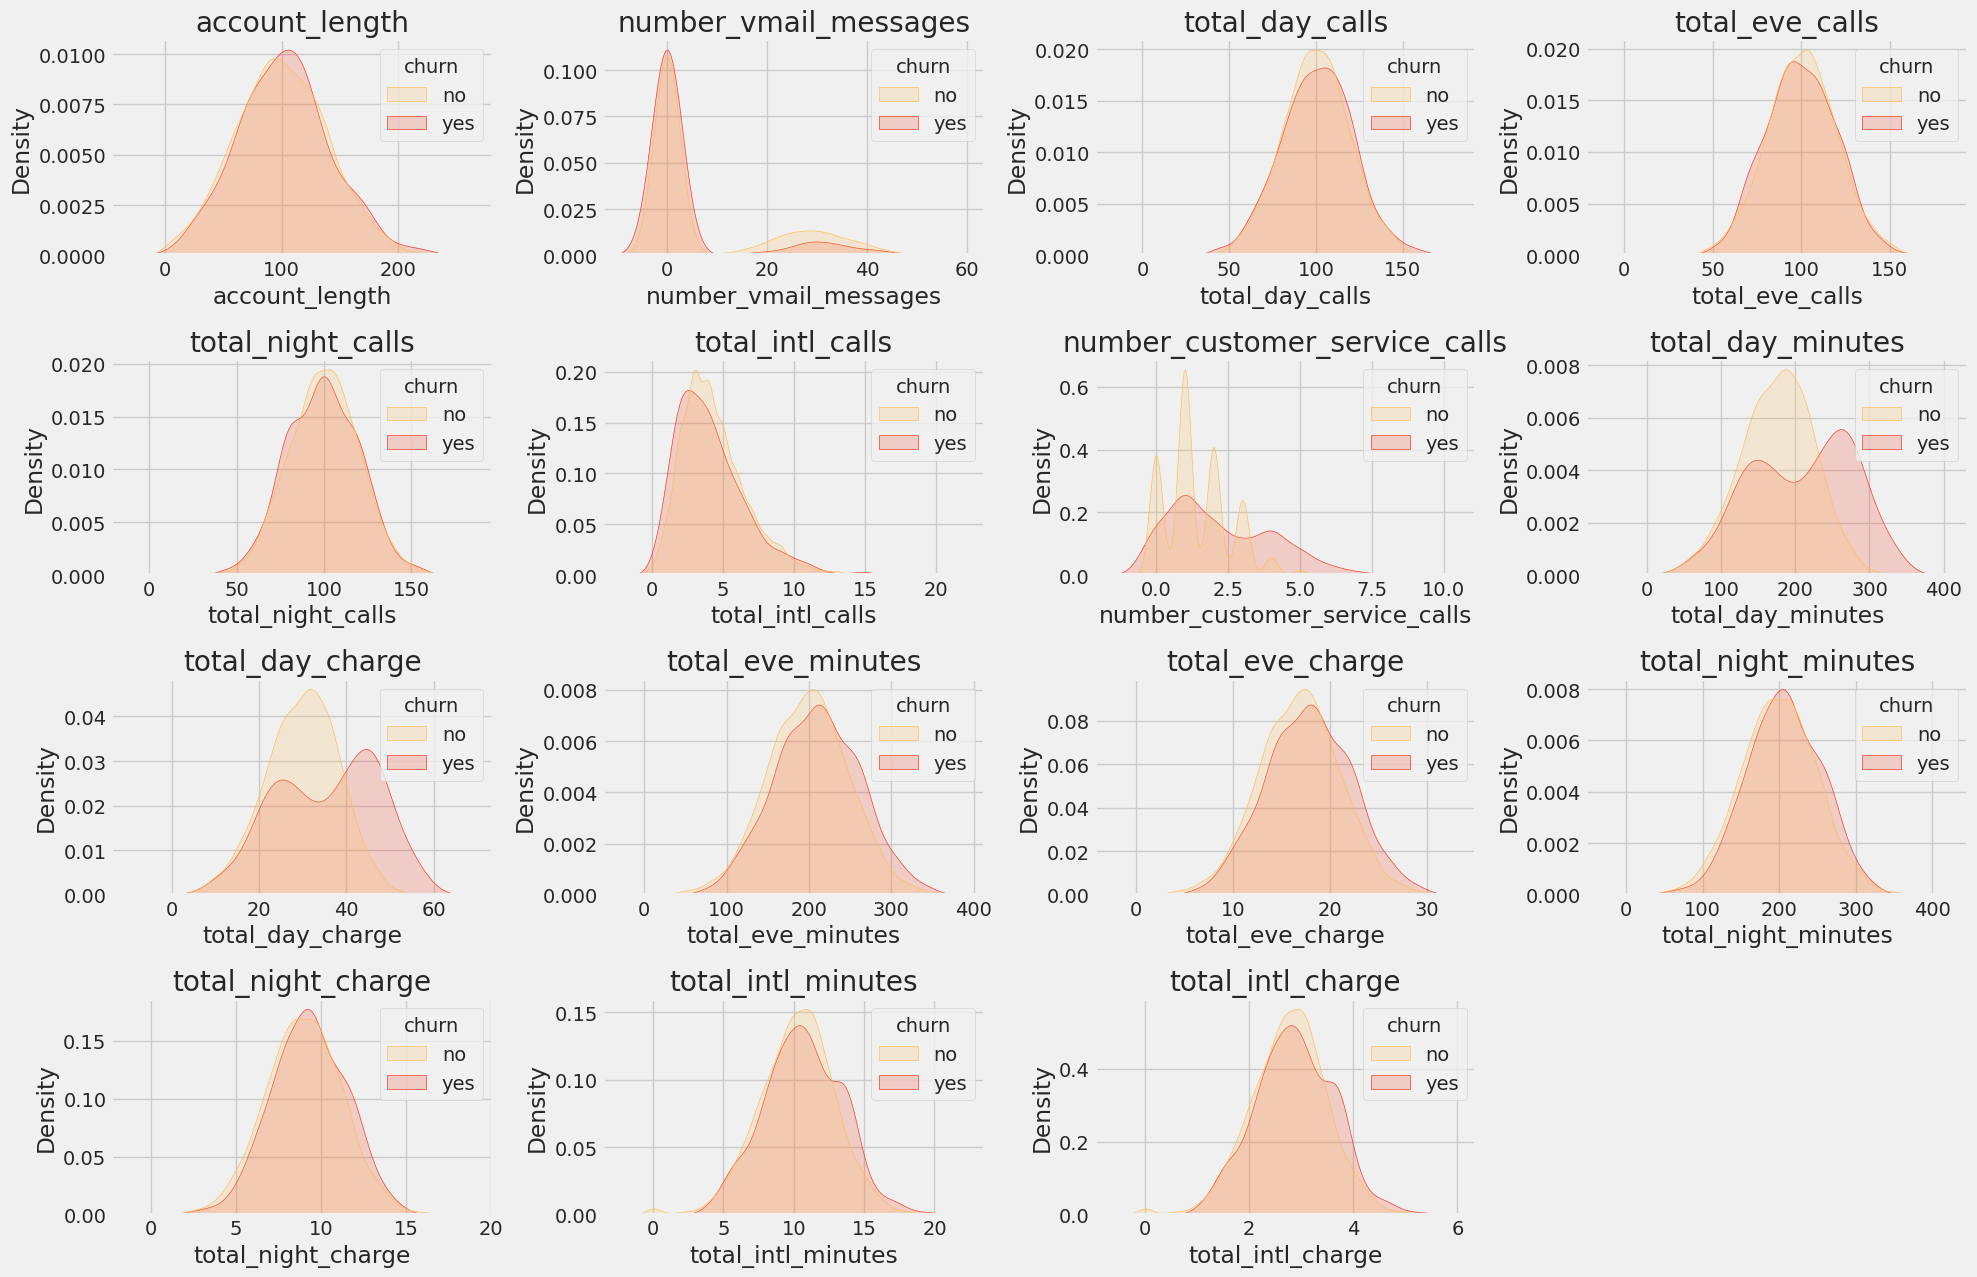

In [ ]:
# This graph shows the density and distribution values for each column separated by column "Churn".

num_cols = 4
num_rows = math.ceil(len(numerical_columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 13))

for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.kdeplot(data=data, x=column, hue="churn",
                fill=True, alpha=.2, palette="YlOrRd",
                common_norm=False, ax=axes[row, col],
                warn_singular=False)\
        .set_title(column)

for i in range(len(numerical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

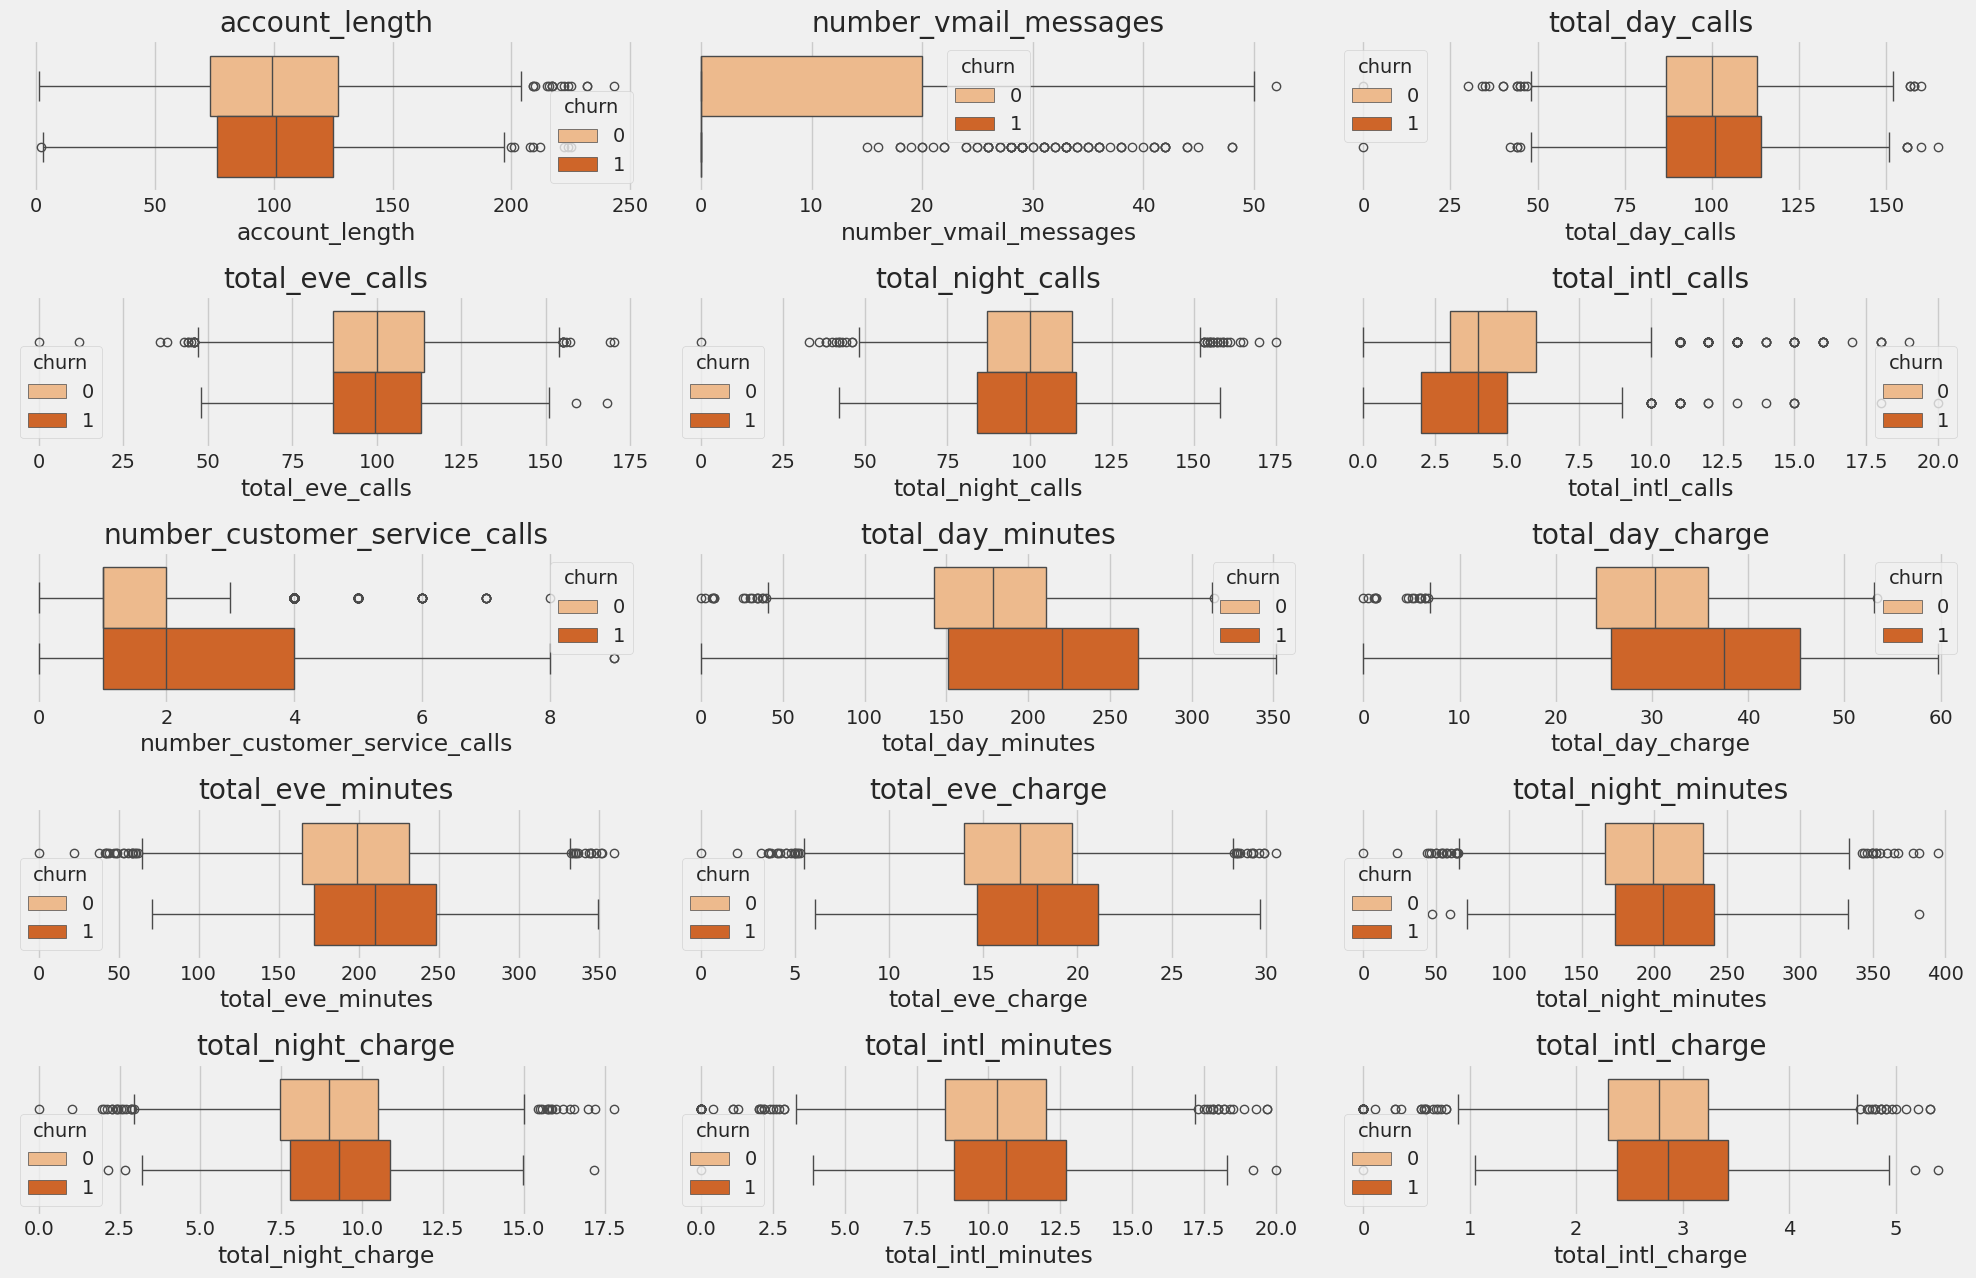

In [41]:
# This graph shows the distribution value using boxplot for each column separated by column "Churn" so we are able to see the outliers for each column.

num_cols = 3
num_rows = math.ceil(len(numerical_columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 13))
for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.boxplot(data = data, x=data[column], ax=axes[row, col], palette="Oranges", hue='churn').set_title(column)

for i in range(len(numerical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

### 3.5. Data Correlation

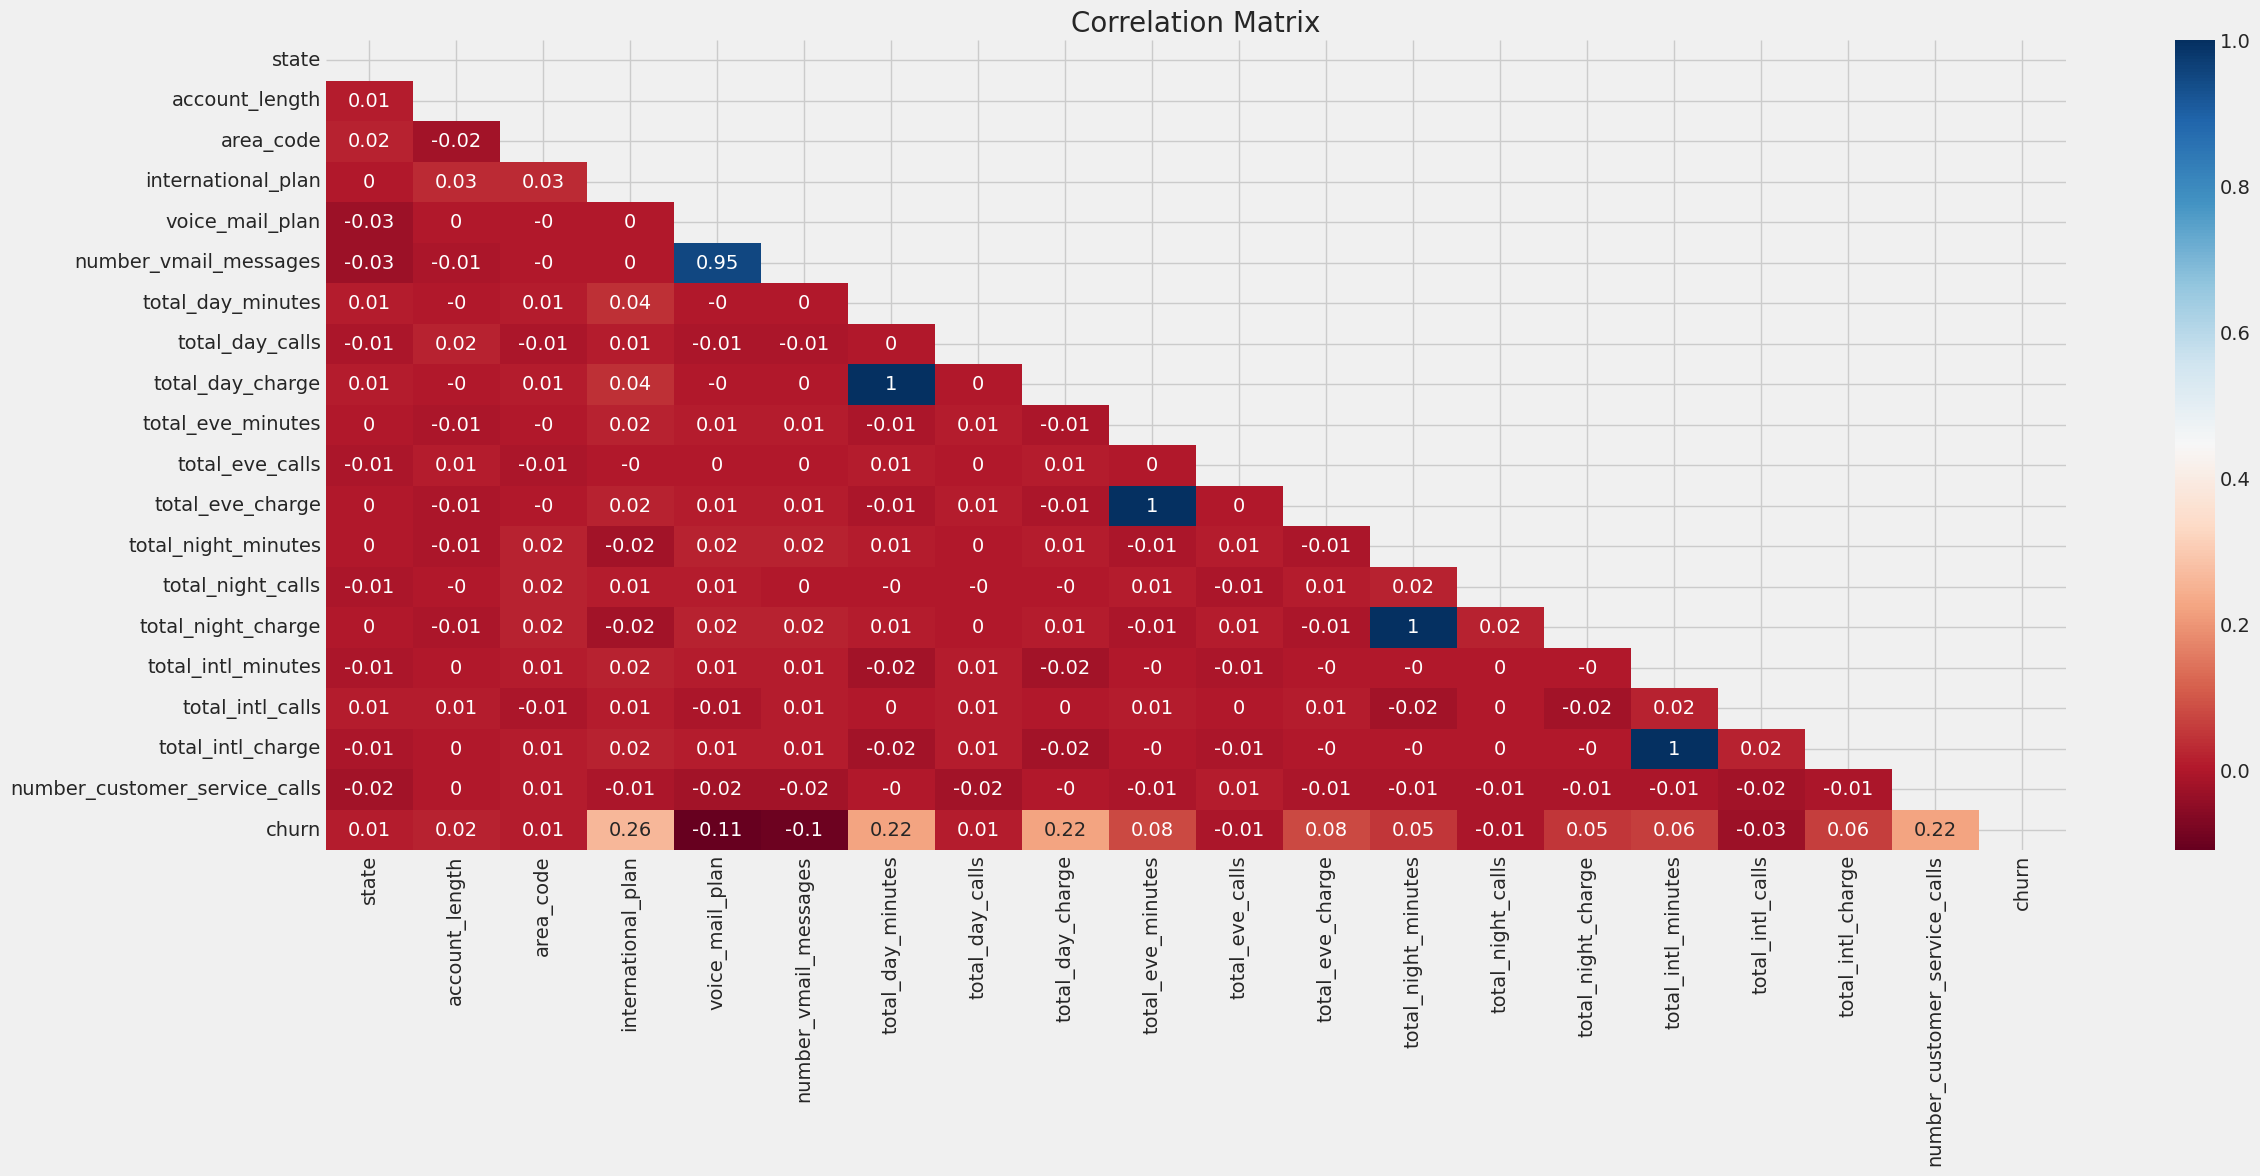

In [44]:
# This graph shows the correlation between columns in the dataset. From this graph, we can know which columns have a huge impact on the target column.

corr_data = data.corr().round(2)

mask = np.zeros_like(corr_data)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(25, 10))
sns.heatmap(corr_data, annot=True, mask=mask, cmap='RdBu')
plt.title("Correlation Matrix", size=20)
plt.show()

# 4. Data Preprocessing

### 4.2. Features Selections (Optional)

In [81]:
# These function is created to reduce number of column that will be used in predicting model. Some

### Pearson Correlation
def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    cor_support = [True if i in cor_feature else False for i in feature_name]
    print(str(len(cor_feature)), 'selected features')
    print(cor_feature)
    return cor_feature

### Chi-Squared
def chi_squared_elimination(X, Y,num_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(X_norm, Y)
    chi_support = chi_selector.get_support()
    chi_feature = X.loc[:,chi_support].columns.tolist()
    print(str(len(chi_feature)), 'selected features')
    print(chi_feature)
    return chi_feature

### Recursive Feature Elimination
def recursive_elimination(X, Y,num_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=num_feats, step=10, verbose=5)
    rfe_selector.fit(X_norm, Y)
    rfe_support = rfe_selector.get_support()
    rfe_feature = X.loc[:,rfe_support].columns.tolist()
    print(str(len(rfe_feature)), 'selected features')
    print(rfe_feature)
    return rfe_feature

### Lasso: SelectFromModel
def lasso_elimination(X, Y, num_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2"), max_features=num_feats)
    embeded_lr_selector.fit(X_norm, Y)
    embeded_lr_support = embeded_lr_selector.get_support()
    embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
    print(str(len(embeded_lr_feature)), 'selected features')
    print(embeded_lr_feature)
    return embeded_lr_feature

### LightGBM: SelectFromModel
def LGBMC_elimination(X, Y, num_feats):
    lgbc=lgb.LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
                reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

    embeded_lgb_selector = SelectFromModel(lgbc, max_features=num_feats)
    embeded_lgb_selector.fit(X, Y)
    embeded_lgb_support = embeded_lgb_selector.get_support()
    embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()
    print(str(len(embeded_lgb_feature)), 'selected features')
    print(embeded_lgb_feature)
    return embeded_lgb_feature

### Tree-based: SelectFromModel
def RFC_elimination (X, Y, num_feats):
    embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feats)
    embeded_rf_selector.fit(X, Y)

    embeded_rf_support = embeded_rf_selector.get_support()
    embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
    print(str(len(embeded_rf_feature)), 'selected features')
    print(embeded_rf_feature)
    return embeded_rf_feature


In [85]:
X = data.drop(columns=['churn'])
Y = data['churn']

num_feats = 5

selected_feature = cor_selector(X, Y,num_feats)
# selected_feature = chi_squared_elimination(X, Y,num_feats)
# selected_feature = recursive_elimination(X, Y,num_feats)
# selected_feature = lasso_elimination(X, Y, num_feats)
# selected_feature = LGBMC_elimination(X, Y, num_feats)
# selected_feature = RFC_elimination(X, Y, num_feats)

X = data[selected_feature]
Y = data['churn']

print(Counter(Y))
sampling = SMOTE()
X, Y = sampling.fit_resample(X, Y)
print(Counter(Y))

Y = pd.get_dummies(Y).values

scaler = PowerTransformer(method='yeo-johnson', standardize=True)
X = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

label = y_train.shape[1]

5 selected features
['international_plan', 'total_day_minutes', 'total_day_charge', 'total_eve_minutes', 'number_customer_service_calls']
Counter({0: 3652, 1: 598})
Counter({0: 3652, 1: 3652})
(5126, 5)
(1447, 5)
(731, 5)


# 5. Neural Network Algoritms

### 5.1. Pre-Processing

In [8]:
# Before jumping to model, we have to pre-process the data. These are the steps :
# 1. Split features and target column
# 2. Oversampling the data so each label has  the same amount of data
# 3. Normalize the data to make predictiong process easier. We use PowerTransformer instead of MinMaxScaler and RobustScaler
# 4. Split the data into training, testing, and validation data

X = data.drop(columns=['churn']).values
Y = data['churn']

print(Counter(Y))
sampling = SMOTE()
X, Y = sampling.fit_resample(X, Y)
print(Counter(Y))

Y = pd.get_dummies(Y).values

# scaler = PowerTransformer(method='yeo-johnson', standardize=True)
scaler = MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

label = y_train.shape[1]

Counter({0: 3652, 1: 598})
Counter({0: 3652, 1: 3652})
(5126, 19) (5126, 2)
(1447, 19) (1447, 2)
(731, 19) (731, 2)


### 5.2. Neural Network Models

In [9]:
# For Neural Network Models, we use DNN, 1D CNN, LSTM, and GRU model.
# For the optimizers, we do experiment by testing RMSProp, SGD, and Adam
# We use categorical_crossentropy loss function since we set target/label to 0 and 1

def DNN_Model():
    model = Sequential()
    model.add(Dense(1024, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(label, activation='softmax'))

    return model

def CNN_Model():
    model = Sequential()

    model.add(Conv1D(64, 3, kernel_regularizer=keras.regularizers.l2(l=0.001), input_shape=(X_train.shape[1], 1)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling1D())

    model.add(Conv1D(32, 3, kernel_regularizer=keras.regularizers.l2(l=0.001)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling1D())

    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(label, activation='softmax'))
    return model

def LSTM_Model():
    model = Sequential()
    model.add((LSTM(256, return_sequences=True, input_shape=(X_train.shape[1], 1))))
    model.add((LSTM(256)))
    model.add(Dense(label, activation='sigmoid'))
    return model

def GRU_Model():
    model = Sequential()
    model.add(GRU(256, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True, return_sequences=True, input_shape = (X_train.shape[1],1)))
    model.add(GRU(256, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True))
    model.add(Dense(label, activation='softmax'))
    return model


# model = DNN_Model()
model = CNN_Model()
# model = LSTM_Model()
# model = GRU_Model()

model.summary()

opt = RMSprop(learning_rate = 0.000_01)
# opt = SGD(learning_rate = 0.000_1)
# opt = Adam(learning_rate = 0.000_01)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 17, 64)            256       
                                                                 
 batch_normalization (BatchN  (None, 17, 64)           256       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 17, 64)            0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 8, 64)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 6, 32)             6176      
                                                                 
 batch_normalization_1 (Batc  (None, 6, 32)            1

### 5.3. Training Model

In [11]:
# This is the process of training the model. We can set the number of epoch and batch size. We don't use early stop in this model.

num_epoch = 100
batch_size = 16

history = model.fit(X_train, y_train, verbose = 2,
                    batch_size = batch_size, epochs = num_epoch,
                    validation_data = (X_val, y_val))

Epoch 1/100
321/321 - 2s - loss: 0.5645 - accuracy: 0.7682 - val_loss: 0.5631 - val_accuracy: 0.7839 - 2s/epoch - 5ms/step
Epoch 2/100
321/321 - 2s - loss: 0.5566 - accuracy: 0.7721 - val_loss: 0.5542 - val_accuracy: 0.7852 - 2s/epoch - 5ms/step
Epoch 3/100
321/321 - 2s - loss: 0.5493 - accuracy: 0.7788 - val_loss: 0.5462 - val_accuracy: 0.7852 - 2s/epoch - 5ms/step
Epoch 4/100
321/321 - 2s - loss: 0.5413 - accuracy: 0.7840 - val_loss: 0.5400 - val_accuracy: 0.7893 - 2s/epoch - 5ms/step
Epoch 5/100
321/321 - 2s - loss: 0.5338 - accuracy: 0.7887 - val_loss: 0.5330 - val_accuracy: 0.8016 - 2s/epoch - 5ms/step
Epoch 6/100
321/321 - 2s - loss: 0.5278 - accuracy: 0.7944 - val_loss: 0.5267 - val_accuracy: 0.8057 - 2s/epoch - 5ms/step
Epoch 7/100
321/321 - 2s - loss: 0.5250 - accuracy: 0.7940 - val_loss: 0.5209 - val_accuracy: 0.8071 - 2s/epoch - 5ms/step
Epoch 8/100
321/321 - 2s - loss: 0.5174 - accuracy: 0.7944 - val_loss: 0.5153 - val_accuracy: 0.8044 - 2s/epoch - 5ms/step
Epoch 9/100
321/

### 5.4. Accuracy and Loss Graph

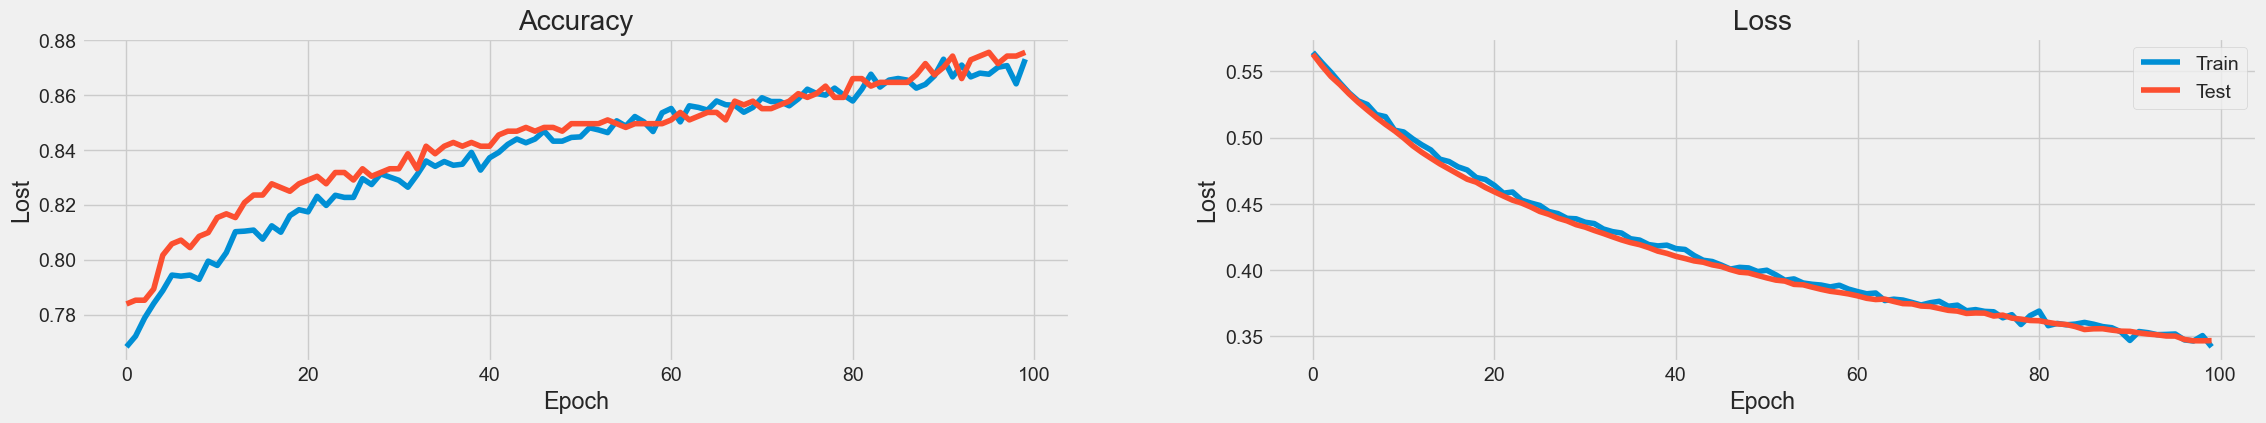

In [12]:
# After the model training process is complete, we can see the accuracy and loos per epoch.

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(25, 4))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Lost')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Lost')

plt.legend(['Train', 'Test'])
plt.show()

### 5.5. Classification Report and Confusion Matrix

In [15]:
# Showing Classification Report such as precision, recall, and f1-score of the model.

y_pred = np.rint(model.predict(X_test, verbose=0)).astype('int')
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88       713
           1       0.90      0.85      0.87       734

   micro avg       0.87      0.87      0.87      1447
   macro avg       0.88      0.88      0.87      1447
weighted avg       0.88      0.87      0.87      1447
 samples avg       0.87      0.87      0.87      1447



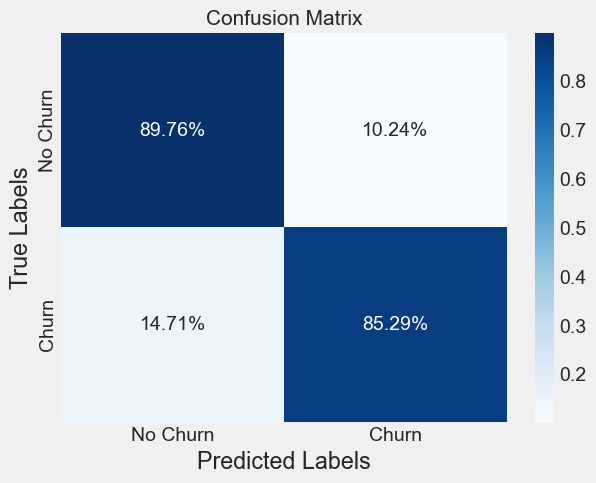

In [14]:
# Showing Confusion Matrix of the Neural Network Model

labels = ['No Churn', 'Churn']

y_pred = np.rint(model.predict(X_test, verbose=0).argmax(axis=1))
con_mat = confusion_matrix(y_test.argmax(axis=1),y_pred)

cm_percent = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix', fontsize = 15)
plt.show()

### 5.6. Make a prediction using the model

In [14]:
# Making prediction using DataTest.csv

# data_test = pd.read_csv('/content/gdrive/MyDrive/Binar - Data Science/Challenge 2/Dataset/DataTest.csv').drop(columns = ['id'])
data_test = pd.read_csv('Dataset\DataTest.csv').drop(columns = ['id'])

change_columns_to_numerical(data_test)

X = data_test.values

scaler = PowerTransformer(method='yeo-johnson', standardize=True)
X = scaler.fit_transform(X)

test_pred = model.predict(X, verbose=0).argmax(axis=1)
test_pred

my_dict = {0 : 'No Churn', 1 : 'Churn'}

test_pred_status = [my_dict[x] for x in test_pred]

data_test['ChurnStatus'] = test_pred_status
data_test

state : ['AK' 'AL' 'AR' 'AZ' 'CA' 'CO' 'CT' 'DC' 'DE' 'FL' 'GA' 'HI' 'IA' 'ID'
 'IL' 'IN' 'KS' 'KY' 'LA' 'MA' 'MD' 'ME' 'MI' 'MN' 'MO' 'MS' 'MT' 'NC'
 'ND' 'NE' 'NH' 'NJ' 'NM' 'NV' 'NY' 'OH' 'OK' 'OR' 'PA' 'RI' 'SC' 'SD'
 'TN' 'TX' 'UT' 'VA' 'VT' 'WA' 'WI' 'WV' 'WY']
area_code : ['area_code_408' 'area_code_415' 'area_code_510']
international_plan : ['no' 'yes']
voice_mail_plan : ['no' 'yes']


,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,ChurnStatus
0,16,128,1,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,No Churn
1,1,118,2,1,0,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0,No Churn
2,12,62,1,0,0,0,120.7,70,20.52,307.2,76,26.11,203.0,99,9.14,13.1,6,3.54,4,No Churn
3,46,93,2,0,0,0,190.7,114,32.42,218.2,111,18.55,129.6,121,5.83,8.1,3,2.19,3,No Churn
4,29,174,1,0,0,0,124.3,76,21.13,277.1,112,23.55,250.7,115,11.28,15.5,5,4.19,3,No Churn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,10,130,1,0,0,0,119.4,99,20.30,226.3,97,19.24,202.7,111,9.12,11.3,7,3.05,0,No Churn
746,47,73,0,0,0,0,177.2,118,30.12,270.5,84,22.99,241.8,112,10.88,12.3,2,3.32,3,No Churn
747,49,152,1,0,0,0,184.2,90,31.31,256.8,73,21.83,213.6,113,9.61,14.7,2,3.97,3,No Churn
748,7,61,1,0,0,0,140.6,89,23.90,172.8,128,14.69,212.4,97,9.56,13.6,4,3.67,1,No Churn


# 6. Supervised Learning

### 6.1. Pre-processing

In [8]:
# Before jumping to Supervised Model, we have to pre-process the data. These are the steps :
# 1. Split features and target column
# 2. Oversampling the data using SMOTE so each label has  the same amount of data
# 3. Normalize the data to make predictiong process easier. We use PowerTransformer instead of MinMaxScaler and RobustScaler
# 4. Split the data into training and testing data

X = data.drop(columns=['churn']).values
Y = data['churn']

print(Counter(Y))
sampling = SMOTE()
X, Y = sampling.fit_resample(X, Y)
print(Counter(Y))

Y = Y.values

# scaler = PowerTransformer(method='yeo-johnson', standardize=True)
scaler = MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.9, random_state = 42)

print(X_train.shape)
print(X_test.shape)

Counter({0: 3652, 1: 598})
Counter({0: 3652, 1: 3652})
(6573, 19)
(731, 19)


### 6.2. Supervised Models

In [9]:
# We use several supervised model to compare which model gives the best result

adaboost = AdaBoostClassifier(n_estimators=100, random_state=42)
bagging = BaggingClassifier(n_jobs=-1)
extraTrees = ExtraTreesClassifier(max_depth=100, n_jobs=-1, random_state=42)
gradient = GradientBoostingClassifier(max_depth=100, n_estimators=100, learning_rate=.01,  random_state=42)
randomForest = RandomForestClassifier(max_depth=100, random_state=42, n_jobs=-1)
histGradient = HistGradientBoostingClassifier()
XGB = XGBClassifier(n_jobs=-1)
knn = KNeighborsClassifier(n_jobs=-1)
decisionTree = DecisionTreeClassifier(random_state=42, max_depth=100)
pac = PassiveAggressiveClassifier(random_state=42)
linear = LogisticRegression(random_state=42)


### 6.3. Training Model with Stacking Classifier

In [22]:
# Training process of Ensemble Model (Stacking Classifier).

model = StackingClassifier([
    ('bagging', bagging),
    ('adaboost', adaboost),
    ('extraTress', extraTrees),
    ('randomforest', randomForest),
    ('decisionTree', decisionTree),
    ('histGradient', histGradient),
    ('XGB', XGB),
    ('pac', pac),
    ('linear', linear),
    ('gradient', gradient),
    ('knn', knn),
], n_jobs=-1)

model.fit(X_train, y_train)

StackingClassifier(estimators=[('bagging', BaggingClassifier(n_jobs=-1)),
                               ('adaboost',
                                AdaBoostClassifier(n_estimators=100,
                                                   random_state=42)),
                               ('extraTress',
                                ExtraTreesClassifier(max_depth=100, n_jobs=-1,
                                                     random_state=42)),
                               ('randomforest',
                                RandomForestClassifier(max_depth=100, n_jobs=-1,
                                                       random_state=42)),
                               ('decisionTree',
                                DecisionTreeClassifier(max_depth=100,
                                                       r...
                                              monotone_constraints=None,
                                              n_estimators=100, n_jobs=-1,
                                              num_parallel_tree=None,
                                              predictor=None, random_state=None, ...)),
                               ('pac',
                                PassiveAggressiveClassifier(random_state=42)),
                               ('linear', LogisticRegression(random_state=42)),
                               ('gradient',
                                GradientBoostingClassifier(learning_rate=0.01,
                                                           max_depth=100,
                                                           random_state=42)),
                               ('knn', KNeighborsClassifier(n_jobs=-1))],
                   n_jobs=-1)

In [23]:
# Testing the model using train and testing data

print("Train Score : ",round((model.score(X_train, y_train)*100), 2),'%')
print("Test Score  : ",round((model.score(X_test, y_test)*100), 2),'%')

Train Score :  100.0 %
Test Score  :  98.08 %


### 6.4. Training Model with Supervised Learning Models

In [30]:
# Training process of supervised models.

# list_models = [adaboost, bagging, extraTrees, gradient, randomForest, histGradient, XGB, knn, decisionTree, pac, linear]
list_models = [ linear]

for model in list_models:
  print(model)
  model.fit(X_train, y_train)
  print("Train Score : ",round((model.score(X_train, y_train)*100), 2),'%')
  print("Test Score  : ",round((model.score(X_test, y_test)*100), 2),'%')
  print()

LogisticRegression(random_state=42)
Train Score :  79.23 %
Test Score  :  80.3 %



In [31]:
# Showing Classification Report such as precision, recall, and f1-score of the model.

y_pred = model.predict(X_test)
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.78      0.83      0.81       364
           1       0.82      0.77      0.80       367

    accuracy                           0.80       731
   macro avg       0.80      0.80      0.80       731
weighted avg       0.80      0.80      0.80       731



### 6.5. Classification Report and Confusion Matrix

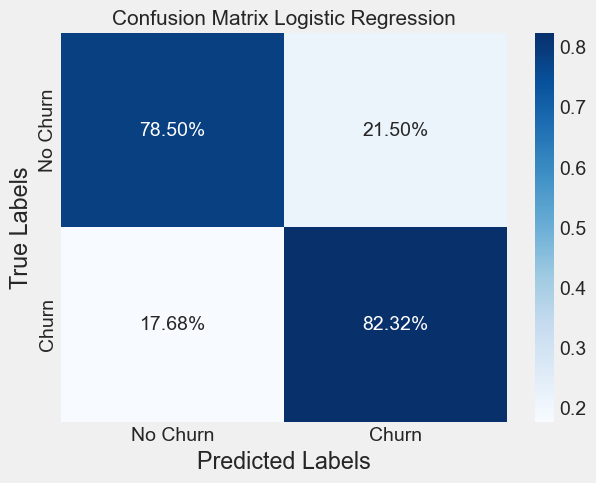

In [23]:
# Showing Confusion Matrix of the Supervised Model

labels = ['No Churn', 'Churn']

y_pred = model.predict(X_test)
con_mat = confusion_matrix(y_test,y_pred)

cm_percent = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Logistic Regression', fontsize = 15)
plt.show()

### 6.5. Make a prediction using the model

In [24]:
# Making prediction using DataTest.csv

# data_test = pd.read_csv('/content/gdrive/MyDrive/Binar - Data Science/Challenge 2/Dataset/DataTest.csv').drop(columns = ['id'])
data_test = pd.read_csv('Dataset\DataTest.csv').drop(columns = ['id'])

change_columns_to_numerical(data_test)

X = data_test.values

scaler = PowerTransformer(method='yeo-johnson', standardize=True)
X = scaler.fit_transform(X)

test_pred = model.predict(X)

my_dict = {0 : 'No Churn', 1 : 'Churn'}

test_pred_status = [my_dict[x] for x in test_pred]

data_test['ChurnStatus'] = test_pred_status
data_test

state : ['AK' 'AL' 'AR' 'AZ' 'CA' 'CO' 'CT' 'DC' 'DE' 'FL' 'GA' 'HI' 'IA' 'ID'
 'IL' 'IN' 'KS' 'KY' 'LA' 'MA' 'MD' 'ME' 'MI' 'MN' 'MO' 'MS' 'MT' 'NC'
 'ND' 'NE' 'NH' 'NJ' 'NM' 'NV' 'NY' 'OH' 'OK' 'OR' 'PA' 'RI' 'SC' 'SD'
 'TN' 'TX' 'UT' 'VA' 'VT' 'WA' 'WI' 'WV' 'WY']
area_code : ['area_code_408' 'area_code_415' 'area_code_510']
international_plan : ['no' 'yes']
voice_mail_plan : ['no' 'yes']


,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,ChurnStatus
0,16,128,1,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,No Churn
1,1,118,2,1,0,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0,No Churn
2,12,62,1,0,0,0,120.7,70,20.52,307.2,76,26.11,203.0,99,9.14,13.1,6,3.54,4,No Churn
3,46,93,2,0,0,0,190.7,114,32.42,218.2,111,18.55,129.6,121,5.83,8.1,3,2.19,3,Churn
4,29,174,1,0,0,0,124.3,76,21.13,277.1,112,23.55,250.7,115,11.28,15.5,5,4.19,3,No Churn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,10,130,1,0,0,0,119.4,99,20.30,226.3,97,19.24,202.7,111,9.12,11.3,7,3.05,0,No Churn
746,47,73,0,0,0,0,177.2,118,30.12,270.5,84,22.99,241.8,112,10.88,12.3,2,3.32,3,No Churn
747,49,152,1,0,0,0,184.2,90,31.31,256.8,73,21.83,213.6,113,9.61,14.7,2,3.97,3,No Churn
748,7,61,1,0,0,0,140.6,89,23.90,172.8,128,14.69,212.4,97,9.56,13.6,4,3.67,1,No Churn
